### ECE/CS/ISyE 524 &mdash; Introduction to Optimization ###

# Sentiment Adjusted Trading Optimization #

#### Will Geister (wgeister@wisc.edu), Student 2 (email address), Student 3 (email address), and Student 4 (email address)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Data Collection](#2-data-collection)
  1. [Stock API + Historical Stock Data](#2a-stock-api--historical-stock-data)
  1. [Twitter API](#2b-twitter-api)
1. [Mathematical Model](#3.-Mathematical-model)
1. [Solution](#4.-Solution)
1. [Results and Discussion](#5.-Results-and-discussion)
1. [Conclusion](#6.-Conclusion)

## 1. Introduction ##

The basic concept behind a stock trading optimizer is fairly simple, and has been gone over in class plenty, what has not been gone over

## 2. Data Collection ##

## 2a. Stock API + Historical Stock Data ##
Our stock data can be broadly broken down into 2 different categories:

- Daily Stock Data
- Historical Stock Data

This project initially started off by using Daily stock data entirely, but this did not provide enough variance to collect adequate stock data so we had to add historic data. We build out our data matrix by giving a bias of 1:1 daily:historical data, building out a matrix that takes both the volatile nature of todays markets and a matrix that has enough stock variance to make some sort of long term predictions

#### Stock Data Collection Historical

Historical stock data can be easily gotten from [kaggle/stock_data](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset?resource=download) and extracted from our sample number of stocks using the python code below:

```python
for ticker in tickers_df['tickers']:
        ticker = ticker.upper()
        filename = f"{ticker}.csv"

        if not os.path.isfile(filename):
            print(f"Warning: File {filename} does not exist. Skipping.")
            continue

        # Read the individual ticker CSV
        df = pd.read_csv(filename)

        # Select and rename the columns
        df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
        df.rename(columns={
            'Date': 'timestamp',
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        }, inplace=True)

        # Add the ticker column
        df['ticker'] = ticker

        # Format timestamp to add '00:00:00'
        df['timestamp'] = df['timestamp'] + ' 00:00:00'

        # Reorder columns
        df = df[['ticker', 'timestamp', 'open', 'high', 'low', 'close', 'volume']]

        master_data.append(df)
```
This then can be fed into a variety of data cleaners, clippers, and modifiers to make the data interface with our combiner later.
#### Stock Data Collection Daily

Large detailed stock datasets were hard to come by, so we had to come up with a strategy to build a large enough dataset within a few acceptance criteria:

- A large array of stocks, given in this project as "stock_tickers.csv" or S
- Stocks that were going to stay relatively stable, for this I selected a list of the companies with the largest market cap descending, and collected as large a data set as possible $(\max(size(S)))$
- Stocks that were freely available with the data from Alpha Vantage (the API used in this project) set of Alpha Vantage given $A$, condition $S \in A$
- Stocks will be picked from the top of the Nasdaq top stock list $S_i = N_i, i = {1,2,3,\dots,n}$
- Number of pulls the API will allow me to do from Wall Street close on Friday to open on Monday (don't know how to express this one as the API throttling seems to happen at random)

Provided mathematically as:

$$\max(size(S))$$

$$s.t.$$

$$S \in A$$

$$S_i = N_i, i = \{ 1,2,3,\dots,n \}$$

n = the number of entries I am able to pull during the weekend the NYSE is closed

#### $$S_i = N_i, i = \{ 1,2,3,\dots,n \}$$
This was a very simple constraint to follow because it just required me to search the NASDAQ for the highest market cap companies and download the 6000 entry long csv of stock valuation and tickers, that I can isolate the tickers on ([nasdq.com/highest market cap](https://www.nasdaq.com/market-activity/index/spx/historical?page=1&rows_per_page=10&timeline=m1)). This data could not be directly used as the stock market is in a state of flux which necessitates a higher amount of granularity see constraint below.

#### $$S \in A$$
This project relies upon the stock data that can be freely procured from the Alpha Vantage API ([alphavantage.co/documentation](https://www.alphavantage.co/documentation/)), this constraint wa probed by using the above constraint set, using error handling for checking if it wasn't in the set (after an 8 hour timeout, that was found to be enough for the API timeout to reset) :

```python
max_retries = 5

...

if not time_series:
            print(f"No time series data found for {symbol}.") #bad data catch
            return
```

#### $$\max(size(S))$$
This function is more served as me running a few scripts periodically throughout the weekend to maximize the number of stocks that can be grabbed from the API. It is run wit this .bat file:

```bat
@echo off

echo Starting up the app...

python -m compileall -q .

python main.py

pause
```
But the pertinent code for this report and this class is this:
```python
for attempt in range(max_retries):
            for i, key in enumerate(keys):
                url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=30min&apikey={key}' ## url to alphavantage
                response = requests.get(url)
                data = response.json()

                if "Meta Data" in data and "Time Series (30min)" in data:
                    print(f"[Key {i + 1}] Success for {symbol}.")
                    break
                else:
                    print(f"[Key {i + 1}] failed or rate-limited. Trying next key...") ## catch if they are limiting my rates (although I am starting to think it is by static ip)

            else:
                print(f"[Attempt {attempt + 1}] All keys failed. Waiting {retry_delay / 60} minutes...")
                if attempt == 3: # ratchet catch to get all the data I could glean so far, will overwrite if I get more data
                    downloader = stockCSVDownloader()
                    downloader.move_to_downloads("stocks.csv") #actual downloader

                    printer = lastStockPrinter()
                    printer.move_last_stock_to_downloads(symbol, str(self.count))
                    continue
                elif attempt == 4:
                    time.sleep(retry_delay * 8) #long sleeper so I can afk this

                time.sleep(retry_delay)
                continue
            break
        else:
            print(f"Failed to fetch data for {symbol} after {max_retries} retries.")
            return
```
This peice of code queries the API and adds the stock data to the csv that will be staged and downloaded after 3 failed attempts (my "soft catch" that hopefully catches when the API starts to throttle me.) after it throttles me, it prints out the last stock to be queried, I turn on a vpn, and continue the process from the last stock ticker it printed out.

All stocks_# are then combined and fed into a variance calculator made in Julia, given below:

```python
using CSV
using DataFrames
using Statistics

df = CSV.read("top_stocks_data.csv", DataFrame)
grouped = groupby(df, :ticker)

results = DataFrame(
    ticker = String[],
    open_variance = Float64[],
    high_variance = Float64[],
    low_variance = Float64[],
    close_variance = Float64[],
    volume_variance = Float64[],
)

for g in grouped
    push!(results, (
        ticker = first(g.ticker),
        open_variance = var(g.open),
        high_variance = var(g.high),
        low_variance = var(g.low),
        close_variance = var(g.close),
        volume_variance = var(g.volume),
    ))
end

CSV.write("stock_variance.csv", results)

println("Variance data was written to stock_variance.csv.")
```
#### Combining the stock data

Because these data sheets (.csv) are theoretically formatted correctly, I combined the via google sheets and uploaded them to then be optimized via our optimizer written in Julia to get the best stocks according to just stock calculation, non-considering the twitter sentiment that will effect the final verdict.



## 2b. Twitter API ##

## 3. Mathematical model ##

$$
\begin{aligned}
\underset{x \in \mathbb{R}^n}{\text{maximize}}\quad & \mathbf{E}^T x \\
\text{subject to:} \quad & \sum_{i=1}^{n} x_i = 1, \\
& x_i \leq \frac{\eta}{100} \quad \text{for all} \quad i = 1, \dots, n, \\
& x_i \geq 0 \quad \text{for all} \quad i = 1, \dots, n
\end{aligned}
$$
Where:
  - $x_i$ represents the allocation to the $i$-th stock in the portfolio.
  - $\mathbf{E}$ is the vector of expected returns for each stock, i.e., $\mu_{NS}$ from the code.
  - The objective function is to maximize the expected return of the portfolio, $\mathbf{E}^T x$, which is the dot product of the expected return vector and the allocation vector.
  - The first constraint ensures that the sum of the allocations is 1, meaning the portfolio is fully invested.
  - The second constraint limits the maximum allocation to any single stock to a percentage parameter given here as $\eta$ this is to make our optimizer be forced to diversify rather than just dumping everything into a high return stock
  - The third constraint ensures that the allocations are non-negative

Additionally, the code incorporates a risk term related to the portfolio's variance or covariance matrix $\sigma$, where the risk is penalized in the objective function. This can be incorporated as follows:
$$
\text{Objective:} \quad \mathbf{E}^T x - \lambda x^T \sigma x \\
$$


Where:
  - $\sigma$ is the covariance matrix of stock returns.
  - $\lambda$ is the risk aversion parameter (set to 0.5 in the code). The term $\lambda x^T \sigma x$ penalizes the variance of the portfolio, thus balancing between maximizing return and minimizing risk.

However this all constitutes how a normal trade optimizer works, our "sentiment-adjusted" trade optimizer adds a new variable into the mix

$$
\begin{aligned}
\underset{x \in \mathbb{R}^n}{\text{maximize}}\quad & \mathbf{E}^T_{SA} x \\
\text{subject to:} \quad & \sum_{i=1}^{n} x_i = 1, \\
& x_i \leq \frac{\eta}{100} \quad \text{for all} \quad i = 1, \dots, n, \\
& x_i \geq 0 \quad \text{for all} \quad i = 1, \dots, n
\end{aligned}
$$
Where:
  - all elements are the same as the past except:
  - $\mathbf{E}_{SA}$ is the vector of expected returns for each stock, The $SA$ portion of the $\mathbf{E}_{SA}$ estimated returns that are calculated using the sentiment predictors i.e., $\mu_{SA}$ from the code.
  - The objective function is to maximize the expected return of the portfolio, while taking into mind the sentiment predictors from the code $\mathbf{E}^T_{SA} x$, which is the dot product of the expected return vector and the allocation vector.

This function still works off of the risk adjusted formula given below as:
$$
\text{Objective:} \quad \mathbf{E}^T_{SA} x - \lambda x^T \sigma x \\
$$

#### Matrix Operations

In the provided optimization models as above, the matrices and vectors may not be explained in enough detail to understand our code portion Matrices are only used on the objective function. A brief explanation for each is provided:

**Matrices are below**

- $\mu$ - `muS` or `muNS` in the code is a vector of expected returns, or in the math above represented by $\mathbf{E}$ (or $\mathbf{E}_{SA}$). It is a $1 \times n$ matrix where $n$ is the number of stocks sampled

- $\sigma$ - or `Sigma` in the code is a covariance matrix of stock returns it is a $n \times n$ matrix where each element $\sigma_ij$ represents the covariance between stock $i$ and stock $j$.

- $x$ - or `x` in the code is a vector of allocation weights to be optimized, where each element $x_i$ represents the weight assigned to the $i$th stock in the portfolio.

**Operations are below:**

- Expected Return Term: $\mu^T \cdot x$ 
  * Shape: $(1, n) \cdot (n)$ gives a scalar  
  * This is the dot product of the expected returns and the allocation vector.

- Risk Term: $x^T \cdot \sigma \cdot x$  
  * Shape: $(1, n) \cdot (n, n) \cdot (n)$ gives a scalar 
  * This computes the quadratic form to represent portfolio variance.

## 4. Implementation ##

As you can probably tell by our project design, we will have two different parts of code, one that calculates stock returns as normal and another that calculates them as a function of the sentiment expressed by certain "high influence" figures' twitter activity. The first two code boxes establish a common stock data set that will be used in the calculations to make the two different predictions in the third and fourth code boxes.


#### SENTIMENT AND NON SENTIMENT PORTION
As you are probably able to tell, this first part runs all of the packages we will use and loads the csv data into a dataframe. We need to calculate the approximate daily return using the formula: $$r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$
where:
- $r_t$ is the return at time t
- $P_t$ is the price at time t

In [13]:
using CSV
using DataFrames
using Statistics
using JuMP
using Ipopt

# Load stock data
stock_data = CSV.read("master_stock_data_sectors.csv", DataFrame)

ticker_sector = CSV.read("tickers_with_sectors.csv", DataFrame)
sector_sentiment = CSV.read("sector_sentiment.csv", DataFrame)

# lookup dictionaries
ticker_to_sector = Dict(row.ticker => row.sector for row in eachrow(ticker_sector))
sector_to_sentiment = Dict(row.Sector => row.Average_Sentiment_Score for row in eachrow(sector_sentiment))

function compute_returns(df)
    df = sort(df, :ticker)
    returns = [missing; diff(df.close) ./ df.close[1:end-1]]
    df[!, :return] = returns
    return df
end

returns_data = combine(groupby(stock_data, :ticker), compute_returns) # Compute returns
returns_wide = unstack(returns_data, :ticker, :return; combine=mean)
returns_wide_clean = dropmissing(returns_wide) # Drop rows with missing returns

println("Data Read IN")

Data Read IN


This is where the first math is done, where the returns are calculated based on the data and stored in `sigma`, this is the final part of code that both the sides of non-sentiment adjustment and the sentiment adjustment side converge.

When we have calculated the returns, we can compute the covariance matrix $\Sigma$ this is a square matrix that describes the covariances between different stocks in the portfolio. This matrix can be given by $$\sigma_{ij} = \text{Cov}(r_i, r_j) = \frac{1}{N-1} \sum_{t=1}^{N} (r_{i,t} - \bar{r}_i)(r_{j,t} - \bar{r}_j)$$ Where: $\sigma_{ij} \in \Sigma = $ `sigma`

In [14]:
clean_stocks = names(returns_wide_clean) # Stocks that have all data
valid_stock_data = filter(row -> row[:ticker] in clean_stocks, stock_data)
returns_matrix = Matrix{Float64}(returns_wide_clean[:, clean_stocks])

sigma = cov(returns_matrix) # Compute the covariance matrix for the returns (sigma)
println("Sigma calculated")

Sigma calculated


#### NON SENTIMENT PORTION

This first chunk of code is our start of our non-sentiment adjusted stock predictor.

The expected return (given in the vector $\mu$) is the difference between the open and close which yeilds:$$\mu_i = \frac{1}{T} \sum_{t=1}^{T} \frac{P_{i,\text{open},t} - P_{i,\text{close},t}}{P_{i,\text{open},t}}$$

In [15]:
muNS = Float64[]

for stock in clean_stocks
    timepoints = subset(valid_stock_data, :ticker => ByRow(==(stock)))

    # Compute return for each row, filtering out bad data
    returns = [(row[:open] - row[:close]) / row[:open] for row in eachrow(timepoints)
               if !ismissing(row[:open]) && !ismissing(row[:close]) && row[:open] != 0.0]

    # Skip stock if no valid returns
    if isempty(returns)
        continue
    end

    expected_return = mean(returns)

    # Skip stock if return is invalid
    if isnan(expected_return) || isinf(expected_return)
        continue
    end

    push!(muNS, expected_return)
end
println("muNS calculated")


muNS calculated


This part of the code fills in elements in the code where there may have been gaps from the pull by extrapolating data from other relevant cells.

Then it runs the optimizer (Optimizer: Quadratic), where the objective is $\min(\text{risk})$ while getting a certian expected return, this function can be represented as: $$\text{Objective} = - \mu^T x + \lambda x^T \Sigma x$$

In [16]:
extra_elements_needed = size(sigma, 1) - length(muNS)
if extra_elements_needed > 0 # If extra elements are needed, add duplicate entries to mu, manually fix data later
    push!(muNS, repeat([muNS[end]], extra_elements_needed)...)
end

lambda = 0.5
model = Model(Ipopt.Optimizer)
n_stocks = length(muNS)

@variable(model, x[1:n_stocks] >= 0)
@constraint(model, sum(x) == 1)

@constraint(model, [i=1:n_stocks], x[i] <= 0.3)  # Limit: max 30% allocation per stock given in the math portion as eta

@objective(model, Min, -muNS' * x + lambda * (x' * sigma * x))

set_optimizer_attribute(model, "print_level", 0)  # silence IPopt

optimize!(model)

println("Optimized")

Optimized


This part is basically for clipping off bad data and making it ready for a csv export

In [17]:
stocks_info = [(clean_stocks[i], value(x[i]), muNS[i]) for i in 1:n_stocks]

# Sort stocks by optimal allocation (descending) for risk categorization
sorted_stocks = sort(stocks_info, by = x -> x[2], rev=true)

# List of tickers to drop <-- this is needed because of empty data slots from our api calls and a generative function that assigns them for unused matrix slots
tickers_to_drop = Set(["open", "close", "high", "low", "volume", "sector", "CCZ"])
filtered_stocks = filter(stock_info -> !(stock_info[1] in tickers_to_drop), sorted_stocks)

# Add sector information to each stock to better understand the sentiment
stocks_with_sectors = [
    (stock[1], stock[2], stock[3], get(ticker_to_sector, stock[1], "Unknown")) 
    for stock in filtered_stocks
]

# Write to CSV, including sector
csv_filename = "top_stocks_no_sentiment.csv"
CSV.write(csv_filename, DataFrame(Stock = [stock[1] for stock in stocks_with_sectors],
                                 Allocation = [stock[2] * 100 for stock in stocks_with_sectors],
                                 ExpectedReturn = [stock[3] * 100 for stock in stocks_with_sectors],
                                 Sector = [stock[4] for stock in stocks_with_sectors]))

println("Results saved to $csv_filename.")

Results saved to top_stocks_no_sentiment.csv.


#### SENTIMENT PORTION

This is our sentiment adjusted portion, below is how heavily the sentiment weight will weigh on the final call on what stocks to buy:

In [19]:
# user-defined weight for sentiment influence
sentiment_weight = 10.0  # ADJUST HERE
println("Sentiment weight saved")

Sentiment weight saved


The expected return (given in the vector $\mu$) is the difference between the open and close which yields:

$$
\mu_i = \frac{1}{T} \sum_{t=1}^{T} \frac{P_{i,\text{open},t} - P_{i,\text{close},t}}{P_{i,\text{open},t}} + \zeta_k * \eta
$$

Where:

$$
\zeta_k \in Z
$$

and $Z$ is the sector-adjusted sentiment score and $k$ is the sector of associated stock $i$.

In [20]:
muS = Float64[]

for stock in clean_stocks
    timepoints = subset(valid_stock_data, :ticker => ByRow(==(stock)))

    # Compute return for each row, filtering out bad data
    returns = [(row[:open] - row[:close]) / row[:open] for row in eachrow(timepoints)
               if !ismissing(row[:open]) && !ismissing(row[:close]) && row[:open] != 0.0]

    # Skip stock if no valid returns
    if isempty(returns)
        continue
    end

    expected_return = mean(returns)

    # Skip stock if return is invalid
    if isnan(expected_return) || isinf(expected_return)
        continue
    end

    # Apply sector sentiment adjustment
    sector = get(ticker_to_sector, stock, nothing)
    sentiment_adjustment = 0.0
    if sector !== nothing
        sentiment_adjustment = get(sector_to_sentiment, sector, 0.0) * sentiment_weight
    else
        ## used to have printer for debugger here
    end

    push!(muS, expected_return + sentiment_adjustment)
end
println("muS Calculated")

muS Calculated


This part of the code fills in elements in the code where there may have been gaps from the pull by extrapolating data from other relevant cells.

Then it runs the optimizer (Optimizer: Quadratic), where the objective is $\min(\text{risk})$ while getting a certian expected return, this function can be represented as: $$\text{Objective} = - \mu^T x + \lambda x^T \Sigma x$$

In [21]:
extra_elements_needed = size(sigma, 1) - length(muS)
if extra_elements_needed > 0 # If extra elements are needed, add duplicate entries to mu, manually fix data later
    push!(muS, repeat([muS[end]], extra_elements_needed)...)
end

lambda = 0.5
model = Model(Ipopt.Optimizer)
n_stocks = length(muS)

@variable(model, x[1:n_stocks] >= 0)
@constraint(model, sum(x) == 1)

@constraint(model, [i=1:n_stocks], x[i] <= 0.3)  # Limit: max 30% allocation per stock given in the math portion as eta

@objective(model, Min, -muS' * x + lambda * (x' * sigma * x))

set_optimizer_attribute(model, "print_level", 0)  # silence IPopt

optimize!(model)

println("Optimized")

Optimized


This part is basically for clipping off bad data and making it ready for a csv export

In [22]:
stocks_info = [(clean_stocks[i], value(x[i]), muS[i]) for i in 1:n_stocks]

# Sort stocks by optimal allocation (descending) for risk categorization
sorted_stocks = sort(stocks_info, by = x -> x[2], rev=true)


# List of tickers to drop <-- this is needed because of empty data slots from our api calls and a generative function that assigns them for unused matrix slots
tickers_to_drop = Set(["open", "close", "high", "low", "volume", "sector", "CCZ"])
filtered_stocks = filter(stock_info -> !(stock_info[1] in tickers_to_drop), sorted_stocks)

# Add sector information to each stock to better understand the sentiment
stocks_with_sectors = [
    (stock[1], stock[2], stock[3], get(ticker_to_sector, stock[1], "Unknown")) 
    for stock in filtered_stocks
]

# Write to CSV, including sector
csv_filename = "top_stocks_with_sentiment.csv"
CSV.write(csv_filename, DataFrame(Stock = [stock[1] for stock in stocks_with_sectors],
                                 Allocation = [stock[2] * 100 for stock in stocks_with_sectors],
                                 ExpectedReturn = [stock[3] * 100 for stock in stocks_with_sectors],
                                 Sector = [stock[4] for stock in stocks_with_sectors]))

println("Results saved to $csv_filename.")

Results saved to top_stocks_with_sentiment.csv.


## 5. Results and discussion ##
Below are the results that we achieved for our predictions; if you notice the stark difference that is because I turned up the sentiment weight up to 10, a good trading strategy would suggest anywhere from $.5 - 3$ for optimal results. This being said, it is much more demonstrative of the sentiment being expressed by certain "people of influence" on X (formerly twitter) and I think better demonstrates the purpose of this project

![without](./without.png)

This is relatively unsurprising as healthcare, technology, and consumer discresonary companies is typically held to be sage trading advice. However with the current sentiment of the people the Twitter/X API was pulling from generally lean right and their bright view on tariffs bringing American heavy industry and energy back tend to pull our results as such

![with](./with.png)

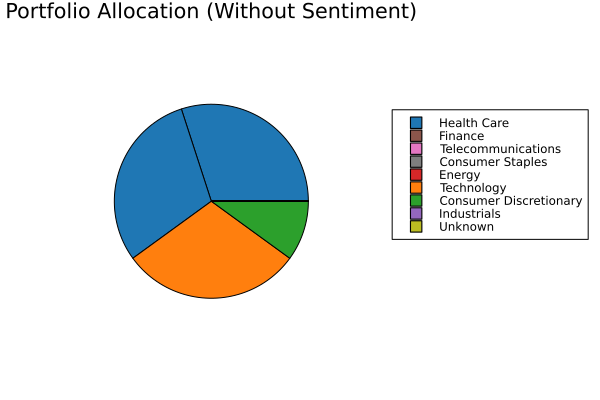

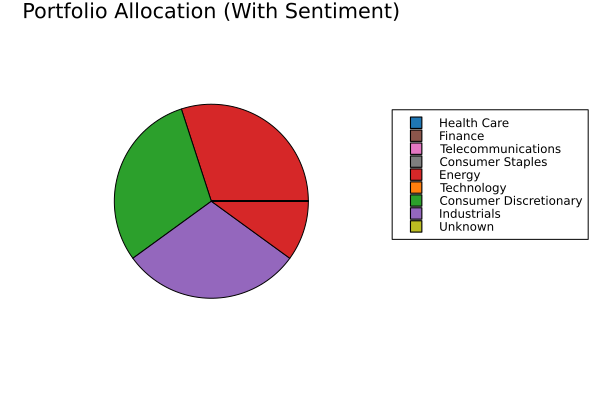

In [30]:
using CSV
using DataFrames
using Plots

function plot_portfolio_pie(df::DataFrame, title_str::String, sector_colors::Dict)
    labels = df.Stock
    allocations = df.Allocation
    sectors = df.Sector

    # Assign colors using the provided sector_colors
    colors = [sector_colors[s] for s in sectors]

    # Create pie chart
    pie_chart = pie(allocations;
        label = false,
        title = title_str,
        c = colors,
        legend = false)

    # Manually add legend entries using invisible scatter points
    for (sector, color) in sector_colors
        scatter!(pie_chart, [NaN], [NaN], label = sector, markercolor = color, markershape = :rect)
    end

    plot!(pie_chart, legend = :outertopright)
    display(pie_chart)
end

# Load the dataframes
df1 = CSV.read("top_stocks_no_sentiment.csv", DataFrame)
df2 = CSV.read("top_stocks_with_sentiment.csv", DataFrame)

# Extract unique sectors from both datasets
unique_sectors = unique(vcat(df1.Sector, df2.Sector))

# Create a consistent color palette based on unique sectors
sector_palette = palette(:tab10)[1:length(unique_sectors)]
sector_colors = Dict(s => c for (s, c) in zip(unique_sectors, sector_palette))

# Plot both datasets with the same sector color mapping
plot_portfolio_pie(df1, "Portfolio Allocation (Without Sentiment)", sector_colors)
plot_portfolio_pie(df2, "Portfolio Allocation (With Sentiment)", sector_colors)


### You can add change the format of sections 2, 3 and 4 to accomodate multiple versions of your model, sensitivity analysis, etc. Just make sure that you answer all the questions we have stated in the final version of your report.

### 4.A. You can also add subsections

#### 4.A.a. or subsubsections
Having more structure in the report can help readers understand your analysis and results!

## 6. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.

## 7. Author Contributions

Note: The contributions in each category must sum to 100%. See Canvas for more details on what type of work belongs in each category.

#### 1. Modelling  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  

  
#### 2. Analysis  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  


#### 3. Data Gathering  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  


#### 4. Software Implementation  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  


#### 5. Report Writing    
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  